In [189]:
import numpy as np
import matplotlib.pyplot as plt

from ppfft.tools.pad import pad
from ppfft.tools.new_fft import new_fft


# Fractional Fourier transform and its adjoint

Let $n \in \mathbb{N}$ and $c \in \mathbb{C}^n$. We denote by $n/2$ the quotient of the division of $n$ by $2$ (which corresponds to ``n//2`` in Python). We define:
$$
\mathcal{D}(n) = 
\begin{cases}
\llbracket - n/2, n/2 - 1\rrbracket &\text{ if } n \text{ is even} \\
\llbracket - n/2, n/2 \rrbracket &\text{ else}
\end{cases}
$$

Let $\beta \in \mathbb{R}$. The $\beta$-Fractional Fourier Transform of $c$ is defined as:
$$
\forall k \in \mathcal{D}(n), \, F^\alpha(c)(k) = \sum_{u \in \mathcal{D}(n)} c(u) \exp\left(-2i \pi \dfrac{\alpha k u}{n} \right)
$$

When $\alpha$ is rational, say $\alpha = \dfrac{a}{b}$, it becomes:
$$
\forall k \in \mathcal{D}(n), \, F^\alpha(c)(k) = \sum_{u \in \mathcal{D}(n)} c(u) \exp\left(-2i \pi \dfrac{a k u}{b n} \right)
$$

Using zero padding and the FFT, we can compute:
$$
\forall k' \in \mathcal{D}(nb), \, F^\alpha(c)(k') = \sum_{u \in \mathcal{D}(n)} c(u) \exp\left(-2i \pi \dfrac{k' u}{b n} \right)
$$

We then have to select the $k'$ values corresponding to the $a k$ ones.

In [5]:
def frac_fft(c: np.ndarray, a: int, b: int, axis=-1):
    """
    frac FFT with alpha = a / b
    """
    shape = np.shape(c)
    n = shape[axis]
    q_n, r_n = divmod(n, 2)
    m = b * n
    q_m, r_m = divmod(m, 2)

    aux_shape = list(shape)
    aux_shape[axis] = m
    aux_shape = tuple(aux_shape)
    aux = pad(c, aux_shape)

    indices = (a * np.arange(-q_n, q_n + r_n)) % m  # between 0 and m - 1
    indices[indices >= q_m + r_m] -= m  # between -m//2 and -1

    indices += q_m

    return np.take(new_fft(aux, axis), indices, axis=axis)


In [6]:
def naive_frac_fourier(x, alpha):
    n = len(x)

    if n % 2 == 0:
        half_n = n//2
        # from -(n//2) to n//2 - 1 : 2*(n//2) = n points
        u = np.arange(-half_n, half_n)
        k = np.arange(-half_n, half_n)

    else:
        half_n = n//2
        # from -(n//2) to n//2 : 2*(n//2) + 1 = n points
        u = np.arange(-half_n, half_n + 1)
        k = np.arange(-half_n, half_n + 1)

    ku = np.exp(-2j * np.pi * alpha * np.einsum("k,u->ku", k, u) / n)
    res = np.einsum("u,ku->k", x, ku)

    return res


In [7]:
n_list = np.arange(10, 20)
a_list = np.arange(1, 7)
b_list = np.arange(2, 6)
l = []

for n in n_list:
    for a in a_list:
        for b in b_list:
            c = np.random.rand(n)
            l.append(np.max(np.abs(frac_fft(c, a, b) - naive_frac_fourier(c, a/b))))

print(np.max(l))


2.2746570558294612e-14


In [8]:
x = np.random.rand(10, 11)

a = 3
b = 5

full = frac_fft(x, a, b)

for i in range(10):
    print(np.max(np.abs(full[i] - frac_fft(x[i], a, b))))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


## Adjoint of ``frac_fft``

In [9]:
from ppfft.tools.frac_fft import frac_fft


ImportError: cannot import name 'frac_fft' from 'ppfft.tools.frac_fft' (/home/loris/Documents/Code/ppfft/src/ppfft/tools/frac_fft.py)

In [10]:
def adj_frac_fft(c, a, b, axis=-1):
    return frac_fft(c, -a, b, axis)


In [11]:
n_list = [4, 5]
a_list = np.arange(-10, 11)
b_list = [2, 3, 4]
err_list = []

for n in n_list:
    for a in a_list:
        for b in b_list:
            x = np.random.rand(n)
            y = np.random.rand(n)
            err_list.append(np.vdot(frac_fft(x, a, b), y) -
                            np.vdot(x, adj_frac_fft(y, a, b)))

print(np.max(np.abs(err_list)))


1.7773310355879576e-15


# Fast frac fft

The frac fft we defined here is actually slow due to zero-padding to size $n^2$ during the ppfft. Here, we define a general frac fft:
$$
\forall u \in \mathcal{D}(n), X(u) = \sum_{j \in \mathcal{D}(n)} x(j) \exp\left(-2i\pi \beta j u \right)
$$

In [12]:
from scipy.signal import czt
from scipy.linalg import matmul_toeplitz
from ppfft.tools.grids import domain

In [13]:
def fast_frac_fft(x, beta, m=None):

    n = len(x)
    w = np.exp(-2j * np.pi * beta)
    # Output size is the same as input.
    if m is None:
        dom = domain(n)
        w_powers = w ** (0.5 * dom ** 2) # this may not be optimal
        c = w ** (- 0.5 * (dom - dom[0]) ** 2)
        return w_powers * matmul_toeplitz((c, c), w_powers * x)
    # Output size given by m.
    else:
        dom_n = domain(n)
        dom_m = domain(m)
        w_powers_n = w ** (0.5 * dom_n ** 2) # this may not be optimal
        w_powers_m = w ** (0.5 * dom_m ** 2) # this may not be optimal
        c = w ** (- 0.5 * (dom_m - dom_n[0]) ** 2)
        r = w ** (- 0.5 * (dom_n - dom_m[0]) ** 2)
        return w_powers_m * matmul_toeplitz((c, r), w_powers_n * x)

In [14]:
def test_fast_frac_fft(x, beta, m=None):

    n = len(x)
    if m is None:
        us = domain(n)
    else:
        us = domain(m)
    
    js = domain(n)

    res = []
    for u in us:
        res.append(np.sum(x * np.exp(-2j * np.pi * beta * u * js)))

    return np.array(res)

In [15]:
n = 1000
x = np.random.rand(n)
beta = np.random.rand()
np.allclose(fast_frac_fft(x, beta), test_fast_frac_fft(x, beta))

True

In [16]:
n = 1001
x = np.random.rand(n)
beta = np.random.rand()
np.allclose(fast_frac_fft(x, beta), test_fast_frac_fft(x, beta))

True

In [17]:
n = 1000
x = np.random.rand(n)
beta = np.random.rand()
np.allclose(fast_frac_fft(x, beta, m=n+1), test_fast_frac_fft(x, beta, m=n+1))

True

In [18]:
n = 1001
x = np.random.rand(n)
beta = np.random.rand()
np.allclose(fast_frac_fft(x, beta, m=n+1), test_fast_frac_fft(x, beta, m=n+1))

True

# For the forward ppfft

For the forward ppfft, we actually need to output $n + 1$ points when the input has size $n$. We want to compute:
$$
\forall u \in \mathcal{D}(n+1), \sum_{j \in \mathcal{D}(n)} x(j) \exp\left(-2i\pi \frac{\alpha j u}{n} \right)
$$

We can see that this is simply the frac_fft we defined above, applied to a *carefully* zero-padded $x$.

In [19]:
def frac_fft_for_ppfft(x, alpha):
    n = len(x)
    return fast_frac_fft(x, alpha / n, m=n+1)

In [20]:
def test_frac_fft_for_ppfft(x, alpha):
    n = len(x)
    q_n, r_n = divmod(n, 2)
    q, r = divmod(n + 1, 2)
    us = np.arange(-q, q + r)
    js = np.arange(-q_n, q_n + r_n)

    res = []
    for u in us:
        res.append(np.sum(x * np.exp(-2j * np.pi * alpha * u * js / n)))

    return np.array(res)

In [21]:
n = 10
x = np.random.rand(n)
alpha = np.random.rand()
np.allclose(test_frac_fft_for_ppfft(x, alpha), frac_fft_for_ppfft(x, alpha))


True

In [22]:
n = 11
x = np.random.rand(n)
alpha = np.random.rand()
np.allclose(test_frac_fft_for_ppfft(x, alpha), frac_fft_for_ppfft(x, alpha))

True

# Fast adjoint

In [23]:
from ppfft.tools.frac_fft import frac_fft_for_ppfft

In [24]:
def adj_frac_fft_for_ppfft(y, alpha):
    n = len(y) - 1
    return fast_frac_fft(y, -alpha / n, m=n)

In [25]:
n = 10
x = np.random.rand(n)
y = np.random.rand(n + 1)
alpha = np.random.rand()

np.isclose(np.vdot(frac_fft_for_ppfft(x, alpha), y), np.vdot(x, adj_frac_fft_for_ppfft(y, alpha)))

True

In [26]:
n = 11
x = np.random.rand(n)
y = np.random.rand(n + 1)
alpha = np.random.rand()

np.isclose(np.vdot(frac_fft_for_ppfft(x, alpha), y), np.vdot(x, adj_frac_fft_for_ppfft(y, alpha)))

True

# Fast inverse

Since the `frac_fft` is implemented using a Toeplitz matrix (which represents a convolution), we can try to invert it using our `InverseToeplitz` class.

In [27]:
from ppfft.resampling.inverse_toeplitz import InverseToeplitz

In [225]:
def inv_frac_fft(y, beta):
    n = len(y)
    w = np.exp(-2j * np.pi * beta)
    # Output size is the same as input.
    dom = domain(n)
    w_powers = w ** (0.5 * dom ** 2) # this may not be optimal.
    c = w ** (- 0.5 * (dom - dom[0]) ** 2)
    toeplitz_inv = InverseToeplitz(c, c)
    return toeplitz_inv.apply_inverse(y / w_powers) / w_powers

# We could put a minus sign when computing w_powers, to replace division by multiplication later.

In [226]:
n = 10
x = np.random.rand(n)

errs = []
betas = np.linspace(0.9, 0, endpoint=False)
for beta in betas:
    y = fast_frac_fft(x, beta)
    errs.append(np.max(np.abs(inv_frac_fft(y, beta) - x)) / np.max(np.abs(x)))


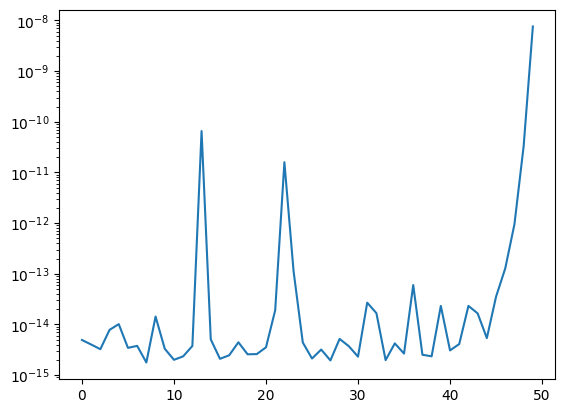

In [227]:
plt.plot(errs)
plt.yscale("log")

In [182]:
n = 100
m = 2 * n + 1
x = np.random.rand(n)
dom = domain(m)

errs = []
for k in dom:
    if k != 0:
        beta = - 2 * k / (n * m)
        y = fast_frac_fft(x, beta)

        errs.append(np.max(np.abs(inv_frac_fft(y, beta) - x)) / np.max(np.abs(x)))
    else:
        errs.append(0)

In [178]:
import matplotlib.pyplot as plt

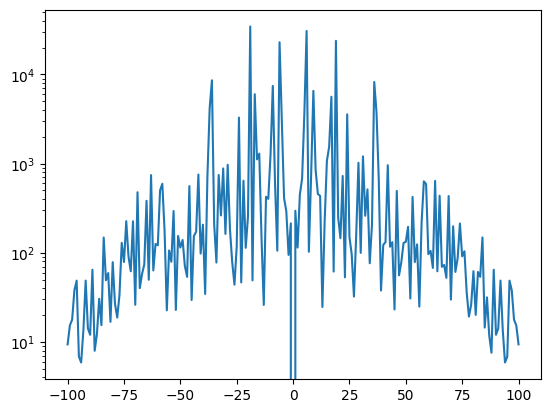

In [183]:
plt.plot(dom, errs)
plt.yscale('log')

Unfortunately, this is not usable because the error is too high. The inverse Toeplitz matrix has a bad condition number, so the numerical accuracy is low, and becomes worse when $n$ grows.